### This notebook shows the creation and usage of an output node that is going to be used for inference
---
[1. Loading the needed functions via the pipeline](#step1)

[2. Create functions needed to create the inference function](#step2)

[3. Do inference using the function](#step3)

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [223]:
import pickle
import random
from pathlib import Path
import sys
from pprint import pprint
from collections import Counter
import pandas as pd
from miniutils import progbar

import yaml
import numpy as np
from sklearn.metrics import f1_score
sys.path.append("../../")

In [217]:
from pytorch_toolbox.pipeline import PipelineGraph
from src.train_with_template import lookups, fit_val
from src.data import Image, match_prediction_probs_with_labels, DataPaths, label_to_string
from src.image import get_image_from_class, plot_rgby, get_unique_classes, convert_to_string, get_image_with_id

#### 1. Loading the needed functions via pipeline <a id='step1'/>

In [24]:
ROOT_SAVE_PATH = Path("../results/densenet121_tta")
CONFIG_FILE = ROOT_FILE_PATH / "config.yml"

In [6]:
with CONFIG_FILE.open("r") as f:
    config = yaml.load(f)

In [7]:
pipeline_graph = PipelineGraph.create_pipeline_graph_from_config(config)

In [8]:
pipeline_graph.sorted_node_names

['LoadTrainingData',
 'CreateDataSplitter',
 'LoadTestingData',
 'CreateTrainingScheme',
 'CreateTimeStampedSavePath',
 'SaveConfiguration',
 'CreateCSVLoggerLearnerCallback',
 'CreateTestAugmentationFunction',
 'CreateSoftF1Loss',
 'CreateSaveModelCallback',
 'CreateSamplerFunction',
 'CreateSampler',
 'CreateResultRecorder',
 'RunRecordResults',
 'CreateOpenImageFunction',
 'CreateNormalizeFunction',
 'CreateModel',
 'CreateLovaszHingeFlatLoss',
 'CreateLabelExtractorCallback',
 'CreateGradientClippingLearnerCallback',
 'CreateFocalLossMetric',
 'CreateFocalLoss',
 'CreateFiveCropTTAPredictionCallback',
 'CreateCallbacksForInference',
 'CreateCallbacks',
 'CreateFiveCropTTAFunction',
 'CreateValidationDataset',
 'CreateTestingDataset',
 'CreateDataBunchForInference',
 'CreateF1SoftMetric',
 'CreateDenormalizeFunction',
 'CreateOutputRecorderLearnerCallback',
 'CreateLearnerCallbacks',
 'CreateAugmentationFunction',
 'CreateTrainingDataset',
 'CreateDataBunch',
 'CreateAccuracyMetric'

##### 2. Create the functions needed to create the inference function <a id='step2'/>

In [9]:
pipeline_graph.run(reference_lookup=lookups, to_node="CreateInference")
create_inference_fn = pipeline_graph.get_node_output("CreateInference")

##### 3. Find the threshold values

In [226]:
def calculate_thresholds():
    first_fold_idx = next(pipeline_graph.get_node_output("CreateDataSplitter")())
    train_idx, val_idx = first_fold_idx
    data = pipeline_graph.get_node_output("CreateDataBunch")(train_idx, val_idx)
    result_recorder = pipeline_graph.get_node_output("CreateResultRecorder")()
    learner = pipeline_graph.get_node_output("CreateLearnerForInference")(data)
    learner.predict_on_dl(dl=learner.data.valid_dl, callbacks=[result_recorder])
    targets = np.stack(result_recorder.targets)
    pred_probs = np.stack(result_recorder.prob_preds)
    thresholds = fit_val(pred_probs, targets)
    thresholds[thresholds < 0.1] = 0.1
    print('Thresholds: ', thresholds)
    print('F1 macro: ', f1_score(targets, pred_probs > thresholds, average='macro'))
    print('F1 macro (th = 0.5): ', f1_score(targets, pred_probs > 0.5, average='macro'))
    print('F1 micro: ', f1_score(targets, pred_probs > thresholds, average='micro'))
    return thresholds

The thresholds are already saved in the root save path, but if you want to recalculate them, you can use the calculate_thresholds() function, keep in mind that you will need to download all the data

In [227]:
# thresholds = calculate_thresholds()

Thresholds:  [0.547154 0.643726 0.564903 0.490089 0.509904 0.528432 0.49584  0.532948 0.447986 0.458288 0.507472 0.570413 0.563899
 0.55711  0.505237 0.140916 0.412934 0.478651 0.464993 0.492406 0.449956 0.491706 0.482765 0.612495 0.434347 0.506804
 0.476294 0.321053]
F1 macro:  0.6134732727624211
F1 macro (th = 0.5):  0.5917777803906201
F1 micro:  0.7515566830296839


In [228]:
thresholds = pickle.load(open(ROOT_SAVE_PATH / "thresholds.p", "rb"))

##### 4. Use the model on some random images

Note here that the images that are used here are from the training, and validation set. So there is a leak in the data. Though since the thresholds are calculated on the validation set, and the model is trained on the training set, there were no ground truth data. Although, the performance of this model can be seen by submitting the submission file that was generated from the model

As there are 709 unique combination of classes, the most common 25 are selected to be used for the example

Note that the code below is not needed, it was only used to find the 25 most common labels

In [333]:
# train_label_df = pd.read_csv(DataPaths.TRAIN_LABELS_ALL_NO_DUPES)
# train_label_df['Target Tuples'] = train_label_df['Target'].map(lambda t: tuple(sorted([int(l) for l in t.split()])))
# labels = train_label_df['Target'].map(lambda t: np.array(sorted([int(l) for l in t.split()])))
# most_common_labels = [t[0] for t in Counter(tuple(label) for label in labels).most_common(25)]
# images_data = []
# for label in progbar(most_common_labels):
#     image_id = train_label_df[train_label_df['Target Tuples'].map(lambda t: t == label)]['Id'].sample(1).values[0]
#     image = get_image_with_id(image_id)
#     images_data.append(dict(label=list(convert_to_string(label)), image_id=image_id, image=image))
# images_save_path = Path("images_data")
# images_save_path.mkdir(parents=True, exist_ok=True)
# pickle.dump(images_data, open(images_save_path / "images_data.p", "wb"))

Now lets load the images data, note that there may be some false positives/true negatives due to the nature of this problem. This is reflected in the F1 scores of ~0.61 for macro and ~0.75 for micro

In [369]:
images_data = pickle.load(open(Path("images_data/images_data.p"), "rb"))

In [370]:
def inference_on_image_data(image_data):
    image = image_data['image']
    _, prediction_probs = create_inference_fn(image)
    predictions = convert_to_string(np.where((prediction_probs > thresholds)==1)[1])
    title = f"Label: {image_data['label']}\nPrediction: {predictions}"
    plot_rgby(image, title=title)

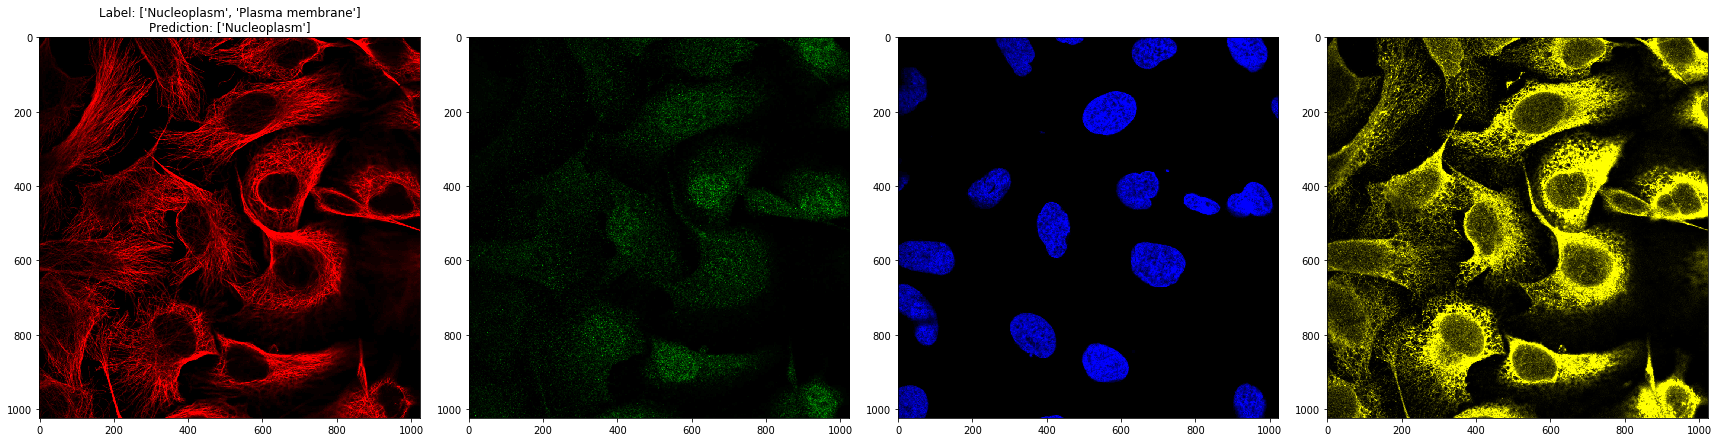

In [371]:
random_image_data = random.sample(images_data, 1)[0]
inference_on_image_data(random_image_data)